### Final Project: Natural language processing

In [11]:
# Importing libraries
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]
import keras
import pandas as pd
import numpy as np
from keras import ops
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string

tfds.disable_progress_bar()

### Loading and Preprocessing Data

In [13]:
# Get the real data from https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
data = pd.read_csv('/Users/ruojiakuang/Desktop/GSB 545 Advanced ML/Final Project/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [21]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

positive    25000
negative    25000
Name: sentiment, dtype: int64


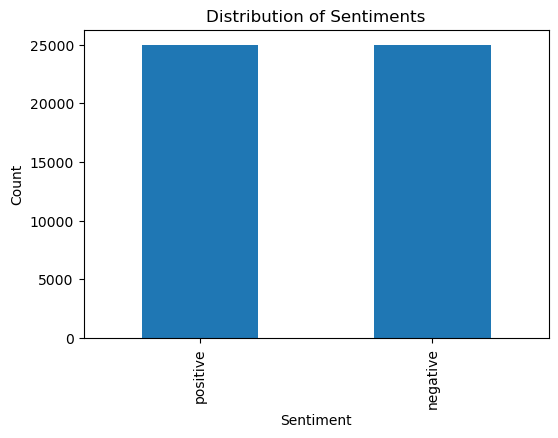

In [23]:
# Check the distribution of the sentiment column
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

As we can see from the graph, the dataset is balanced. 

In [15]:
# Convert the DataFrame to a TensorFlow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('sentiment')
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size)
    return dataset

# Parameters
batch_size = 32

# Create the dataset
dataset = df_to_dataset(data, batch_size=batch_size)

# Inspect the dataset
for feature_batch, label_batch in dataset.take(1):
    print('Features:', feature_batch)
    print('Labels:', label_batch)

Features: {'review': <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'This film, The Alamo:Thirteen Days to Glory, is utter rubbish. The acting is awful, it is far too patriotic and its historical accuracy is not always at its best (Historians would have a field day). It does have a few good moments but not enough to keep interest because it is far too long. Rating * out of **********.',
       b"They're showing this on some off-network. It's well crap. While it is not as bad as the B-movies they show on the Sci-fi network on Saturdays but still a fairly large pile of crap. The acting is passable. The plot and writing are fairly sub-standard and the pacing is entirely too slow. Every minute of the movie feels like the part of the movie where they're wrapping things up before the credits - not the peak of the movie, the denouement. Also, large portions of the cast look way to old for the age range they're playing. The whole thing is predictable, boring and not worthy of being watc

2024-06-09 22:59:13.866199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
val_split = 2500
test_split = 2500
train_split = 7500

# Separating the negative and positive samples for manual stratification
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Creating training, validation and testing splits
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# Remaining pool of samples are stored separately. These are only labeled as and when required
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Creating TF Datasets for faster prefetching and parallelization
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices(
    (x_pool_negatives, y_pool_negatives)
)
pool_positives = tf.data.Dataset.from_tensor_slices(
    (x_pool_positives, y_pool_positives)
)

print(f"Initial training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")

Initial training set size: 15000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 12500
Unlabeled positive pool: 12500


### Fitting the TextVectorization layer
Since we are working with text data, we will need to encode the text strings as vectors which would then be passed through an Embedding layer. To make this tokenization process faster, we use the map() function with its parallelization functionality.

In [18]:
vectorizer = layers.TextVectorization(
    3000, standardize="lower_and_strip_punctuation", output_sequence_length=150
)
# Adapting the dataset
vectorizer.adapt(
    train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256)
)


def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label


train_dataset = train_dataset.map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)
pool_negatives = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(256).map(
    vectorize_text, num_parallel_calls=tf.data.AUTOTUNE
)

2024-06-09 22:59:59.455135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

### Creating and Training the Model

In [19]:
def create_model():
    model = keras.models.Sequential(
        [
            layers.Input(shape=(150,)),
            layers.Embedding(input_dim=3000, output_dim=128),
            layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
            layers.GlobalMaxPool1D(),
            layers.Dense(20, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.summary()
    return model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 150, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,537 (1.63 MB)

 Trainable params: 426,537 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - binary_accuracy: 0.6417 - false_negatives_1: 2217.4204 - false_positives_1: 5342.6436 - loss: 0.6520
Epoch 1: val_loss improved from inf to 0.64154, saving model to FullModelCheckpoint.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 274ms/step - binary_accuracy: 0.6415 - false_negatives_1: 2248.7341 - false_positives_1: 5360.8989 - loss: 0.6521 - val_binary_accuracy: 0.6592 - val_false_negatives_1: 437.0000 - val_false_positives_1: 1267.0000 - val_loss: 0.6415
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - binary_accuracy: 0.7186 - false_negatives_1: 1793.4968 - false_positives_1: 3827.3120 - loss: 0.5834
Epoch 2: val_loss improved from 0.64154 to 0.47119, saving model to FullModelCheckpoint.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 290ms/step - binary_accuracy: 0.7187 - false_negatives_1: 1807.4493 - false_positives_1: 3845.9746 - loss: 0.5833 - val_binary_accuracy: 0.7954 - val_false_negatives_1: 642.0000 - val_false_positives_1: 3

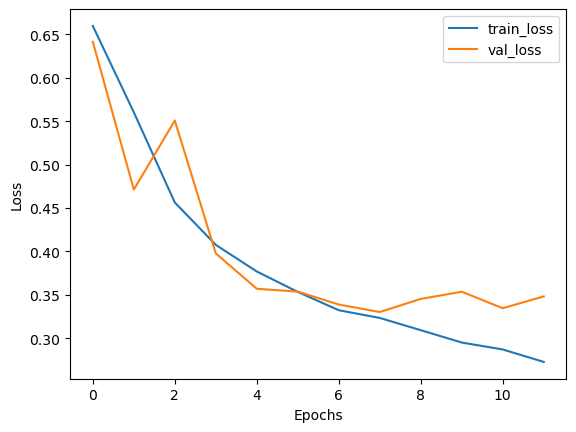

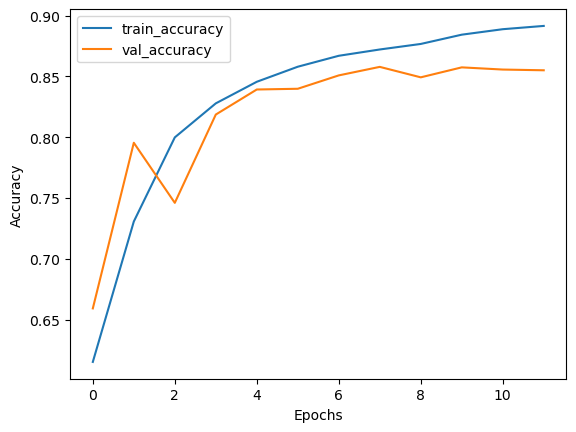

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.8575999736785889, 'false_negatives_1': 340.0, 'false_positives_1': 372.0, 'loss': 0.32876381278038025}
----------------------------------------------------------------------------------------------------


In [20]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # We will save the best model at every epoch and load the best one for evaluation on the test set
    history = model.fit(
        full_train_dataset.batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=4, verbose=1),
            keras.callbacks.ModelCheckpoint(
                "FullModelCheckpoint.keras", verbose=1, save_best_only=True
            ),
        ],
    )

    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = keras.models.load_model("FullModelCheckpoint.keras")

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)
    return model


# Sampling the full train dataset to train on
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

# Training the full model
full_dataset_model = train_full_model(full_train_dataset, val_dataset, test_dataset)

### Training via Active Learning

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 150, 128)       │       384,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 150, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,537 (1.63 MB)

 Trainable params: 426,537 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Starting to train with 15000 samples
Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - binary_accuracy: 0.5058 - false_negatives_2: 2007.6610 - false_positives_2: 1746.8644 - loss: 0.6930
Epoch 1: val_loss improved from inf to 0.68856, saving model to AL_Model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 26s 315ms/step - binary_accuracy: 0.5061 - false_negatives_2: 2044.2833 - false_positives_2: 1767.4000 - loss: 0.6930 - val_binary_accuracy: 0.5336 - val_false_negatives_2: 2263.0000 - val_false_positives_2: 69.0000 - val_loss: 0.6886
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - binary_accuracy: 0.5787 - false_negatives_2: 2232.8982 - false_positives_2: 896.6949 - loss: 0.6812
Epoch 2: val_loss improved from 0.68856 to 0.62494, saving model to AL_Model.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 298ms/step - binary_accuracy: 0.5792 - false_negatives_2: 2258.0000 - false_positives_2: 916.4500 - loss: 0.6810 - val_binary_accuracy: 0.7104 - val_false_negatives_2: 670.0000 - val_false_positives_

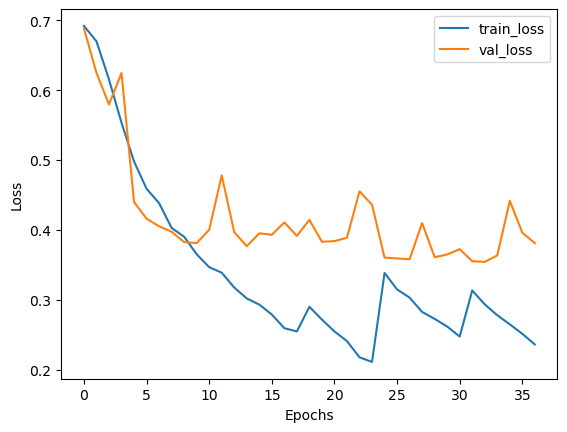

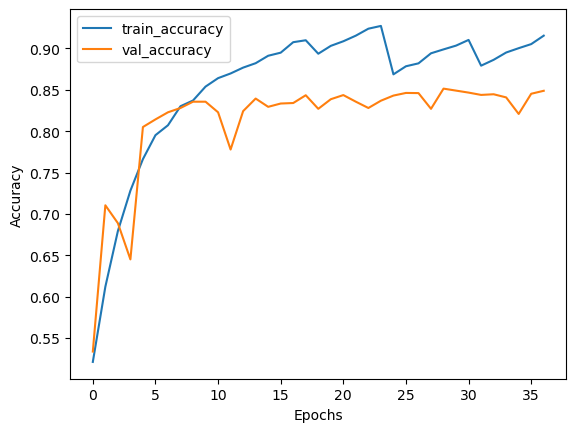

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'binary_accuracy': 0.8432000279426575, 'false_negatives_5': 504.0, 'false_positives_5': 280.0, 'loss': 0.3711091876029968}
----------------------------------------------------------------------------------------------------


In [24]:
def train_active_learning_models(
    train_dataset,
    pool_negatives,
    pool_positives,
    val_dataset,
    test_dataset,
    num_iterations=3,
    sampling_size=5000,
):

    # Creating lists for storing metrics
    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    model = create_model()
    # We will monitor the false positives and false negatives predicted by our model
    # These will decide the subsequent sampling ratio for every Active Learning loop
    model.compile(
        loss="binary_crossentropy",
        optimizer="rmsprop",
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.FalseNegatives(),
            keras.metrics.FalsePositives(),
        ],
    )

    # Defining checkpoints.
    # The checkpoint callback is reused throughout the training since it only saves the best overall model.
    checkpoint = keras.callbacks.ModelCheckpoint(
        "AL_Model.keras", save_best_only=True, verbose=1
    )
    # Here, patience is set to 4. This can be set higher if desired.
    early_stopping = keras.callbacks.EarlyStopping(patience=4, verbose=1)

    print(f"Starting to train with {len(train_dataset)} samples")
    # Initial fit with a small subset of the training set
    history = model.fit(
        train_dataset.cache().shuffle(20000).batch(256),
        epochs=20,
        validation_data=val_dataset,
        callbacks=[checkpoint, early_stopping],
    )

    # Appending history
    losses, val_losses, accuracies, val_accuracies = append_history(
        losses, val_losses, accuracies, val_accuracies, history
    )

    for iteration in range(num_iterations):
        # Getting predictions from previously trained model
        predictions = model.predict(test_dataset)

        # Generating labels from the output probabilities
        rounded = ops.where(ops.greater(predictions, 0.5), 1, 0)

        # Evaluating the number of zeros and ones incorrrectly classified
        _, _, false_negatives, false_positives = model.evaluate(test_dataset, verbose=0)

        print("-" * 100)
        print(
            f"Number of zeros incorrectly classified: {false_negatives}, Number of ones incorrectly classified: {false_positives}"
        )

        # This technique of Active Learning demonstrates ratio based sampling where
        # Number of ones/zeros to sample = Number of ones/zeros incorrectly classified / Total incorrectly classified
        if false_negatives != 0 and false_positives != 0:
            total = false_negatives + false_positives
            sample_ratio_ones, sample_ratio_zeros = (
                false_positives / total,
                false_negatives / total,
            )
        # In the case where all samples are correctly predicted, we can sample both classes equally
        else:
            sample_ratio_ones, sample_ratio_zeros = 0.5, 0.5

        print(
            f"Sample ratio for positives: {sample_ratio_ones}, Sample ratio for negatives:{sample_ratio_zeros}"
        )

        # Sample the required number of ones and zeros
        sampled_dataset = pool_negatives.take(
            int(sample_ratio_zeros * sampling_size)
        ).concatenate(pool_positives.take(int(sample_ratio_ones * sampling_size)))

        # Skip the sampled data points to avoid repetition of sample
        pool_negatives = pool_negatives.skip(int(sample_ratio_zeros * sampling_size))
        pool_positives = pool_positives.skip(int(sample_ratio_ones * sampling_size))

        # Concatenating the train_dataset with the sampled_dataset
        train_dataset = train_dataset.concatenate(sampled_dataset).prefetch(
            tf.data.AUTOTUNE
        )

        print(f"Starting training with {len(train_dataset)} samples")
        print("-" * 100)

        # We recompile the model to reset the optimizer states and retrain the model
        model.compile(
            loss="binary_crossentropy",
            optimizer="rmsprop",
            metrics=[
                keras.metrics.BinaryAccuracy(),
                keras.metrics.FalseNegatives(),
                keras.metrics.FalsePositives(),
            ],
        )
        history = model.fit(
            train_dataset.cache().shuffle(20000).batch(256),
            validation_data=val_dataset,
            epochs=20,
            callbacks=[
                checkpoint,
                keras.callbacks.EarlyStopping(patience=4, verbose=1),
            ],
        )

        # Appending the history
        losses, val_losses, accuracies, val_accuracies = append_history(
            losses, val_losses, accuracies, val_accuracies, history
        )

        # Loading the best model from this training loop
        model = keras.models.load_model("AL_Model.keras")

    # Plotting the overall history and evaluating the final model
    plot_history(losses, val_losses, accuracies, val_accuracies)
    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model


active_learning_model = train_active_learning_models(
    train_dataset, pool_negatives, pool_positives, val_dataset, test_dataset
)

### Conclusion

The model has 0.8432 accuracy rate and lower false positive of 280 comparing to 372. 

Active Learning has cost-efficiency benefits, as it eliminates the need to annotate large amounts of data, saving resources.